* limpeza de dados - OK
* NA - eliminação de todos os Nas
* Feature Engineer - Não foram criadas novas features
* Data Preparation - Não foi realizada
* Data Filtering - 
    * Linhas: Selecionamos apenas  1 > "trip_duration" < 84
    * Colunas: 

# 1. Imports

In [2]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## 1.1. Helper Functions

In [34]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1)/ (n-1))
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

## 1.2. Load Data

In [84]:
df_raw_01 = pd.read_parquet("../data/green_tripdata_2021-01.parquet")
df_raw_02 = pd.read_parquet("../data/green_tripdata_2021-02.parquet")
df_raw_03 = pd.read_parquet("../data/green_tripdata_2021-03.parquet")
df_raw_04 = pd.read_parquet("../data/green_tripdata_2021-04.parquet")
df_raw_05 = pd.read_parquet("../data/green_tripdata_2021-05.parquet")
df_raw_06 = pd.read_parquet("../data/green_tripdata_2021-06.parquet")

In [85]:
df_raw_01.shape[0] + df_raw_02.shape[0] + df_raw_03.shape[0] + df_raw_04.shape[0] + df_raw_05.shape[0] + df_raw_06.shape[0]

486775

In [86]:
# merge data
aux1 = pd.concat([df_raw_01, df_raw_02], axis=0)
aux2 = pd.concat([df_raw_03, df_raw_04], axis=0)
aux3 = pd.concat([df_raw_05, df_raw_06], axis=0)


aux_int = pd.concat([aux1, aux2], axis=0)
df_raw = pd.concat([aux_int, aux3], axis=0)

In [87]:
df_raw.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [88]:
df_raw.shape

(486775, 20)

In [89]:
pickle.dump(df_raw, open("../data/processed/df_raw.pkl", "wb"))

# 2. Descriptive Analysis

In [90]:
df1 = pickle.load(open("../data/processed/df_raw.pkl", "rb"))

## 2.1. Data Dictionary

- **VendorID:** A code indicating the LPEP provider that provided the record (1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.)
- **lpep_pickup_datetime:** The date and time when the meter was engaged.
- **lpep_dropoff_datetime** The date and time when the meter was disengaged.
- **Store_and_fwd_flag** This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. (Y= store and forward trip; N= not a store and forward trip)
- **RateCodeID:** The final rate code in effect at the end of the trip.(1= Standard rate; 2=JFK; 3=Newark; 4=Nassau or Westchester; 5=Negotiated fare; 6=Group ride)
- **PULocationID:** TLC Taxi Zone in which the taximeter was engaged
- **DOLocationID** TLC Taxi Zone in which the taximeter was disengaged
- **Passenger_count:** The number of passengers in the vehicle. This is a driver-entered value.
- **Trip_distance:** The elapsed trip distance in miles reported by the taximeter.
- **Fare_amount:** The time-and-distance fare calculated by the meter.
- **Extra:** Miscellaneous extras and surcharges. Currently, this only includesthe 0.50 and $1 rush hour and overnight charges.
- **MTA_tax:** $0.50 MTA tax that is automatically triggered based on the metered rate in use.
- **Tip_amount:** This field is automatically populated for credit card tips. Cash tips are not included.
- **Tolls_amount:** Total amount of all tolls paid in trip.
- **Improvement_surcharge:** $0.30 improvement surcharge assessed on hailed trips at the flag drop. The improvement surcharge began being levied in 2015.
- **Total_amount** The total amount charged to passengers. Does not include cash tips.
- **Payment_type:** A numeric code signifying how the passenger paid for the trip. (1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip)
- **Trip_type:** A code indicating whether the trip was a street-hail or a dispatch that is automatically assigned based on the metered rate in use but can be altered by the driver. (1= Street-hail; 2= Dispatch)

## 2.2. Data Cleaning

In [91]:
# lowercase columns names
df1.columns = df1.columns.str.lower()

# make columns names more understandable
df1.rename(columns={'vendorid': 'vendor_id',
                    'ratecodeid': 'ratecode_id',
                    'pulocationid': 'pick_up_location_id',
                    'dolocationid': 'drop_off_location_id'}, inplace=True)

In [9]:
## change features values to make eda step more understandable
#
## vendor_id
#df1['vendor_id'] = df1['vendor_id'].apply(lambda x: "Creative Mobile Technologies" if x == 1 else "VeriFone Inc.")
#
## ratecode_id
#df1['ratecode_id'] = df1['ratecode_id'].apply(lambda x: "Standard rate" if x == 1
#                                            else "JFK" if x == 2
#                                            else "Newark" if x == 3
#                                            else "Nassau or Westchester" if x == 4
#                                            else "Negotiated fare" if x == 5
#                                            else "Group ride" if x == 6
#                                            else str(x))
#
## store_and_fwd_flag
#df1['store_and_fwd_flag'] = df1['store_and_fwd_flag'].apply(lambda x: "no" if x == "N" else "yes")
#
## payment_type 1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip
#df1['payment_type'] = df1['payment_type'].apply(lambda x: "Credit card" if x == 1 
#                                                else "Cash" if x == 2
#                                                else "No charge" if x == 3
#                                                else "Dispute" if x == 4
#                                                else "Unknown" if x == 5
#                                                else "Voided trip" if x == 6
#                                                else x)
#
## trip_type
#df1['trip_type'] = df1['trip_type'].apply(lambda x: "Street-hail" if x == 1 else "Dispatch")


In [92]:
# create the target variable
df1['trip_duration'] = df1['lpep_dropoff_datetime'] - df1['lpep_pickup_datetime']
df1['trip_duration'] = df1['trip_duration'].dt.total_seconds() / 60

In [93]:
df1.head()

,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pick_up_location_id,drop_off_location_id,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


## 2.3. Data Dimensions

In [94]:
df1.shape

(486775, 21)

## 2.4. Data Types

In [95]:
df1.dtypes

vendor_id                         int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
ratecode_id                     float64
pick_up_location_id               int64
drop_off_location_id              int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
trip_duration                   float64
dtype: object

In [96]:
# change data types
df1['pick_up_location_id'] = df1['pick_up_location_id'].astype(str)
df1['drop_off_location_id'] = df1['drop_off_location_id'].astype(str)
df1['ratecode_id'] = df1['ratecode_id'].astype(str)

## 2.5. Check NA

In [97]:
df1.isna().sum().sort_values(ascending=False) / df1.shape[0]

ehail_fee                1.000000
congestion_surcharge     0.444963
store_and_fwd_flag       0.444963
trip_type                0.444963
payment_type             0.444963
passenger_count          0.444963
vendor_id                0.000000
tip_amount               0.000000
total_amount             0.000000
improvement_surcharge    0.000000
tolls_amount             0.000000
extra                    0.000000
mta_tax                  0.000000
lpep_pickup_datetime     0.000000
fare_amount              0.000000
trip_distance            0.000000
drop_off_location_id     0.000000
pick_up_location_id      0.000000
ratecode_id              0.000000
lpep_dropoff_datetime    0.000000
trip_duration            0.000000
dtype: float64

In [98]:
## Remove the missing values
df1 = df1.drop('ehail_fee', axis=1)
#df1 = df1.dropna()
#
## since we won't have these features on the prediction moment we will drop them

In [99]:
df1.shape

(486775, 20)

## 2.6. Descriptive Statistics

In [100]:
num_data = df1.select_dtypes(include=['int64', 'float64'])
cat_data = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.6.1. Numerical Statistics

In [101]:
num_data.head()

,vendor_id,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration
0,2,1.0,1.01,5.5,0.5,0.5,0.00,0.0,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,1.0,2.53,10.0,0.5,0.5,2.81,0.0,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,1.0,1.12,6.0,0.5,0.5,1.00,0.0,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,1.0,1.99,8.0,0.5,0.5,0.00,0.0,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,-0.3,-52.80,3.0,1.0,0.00,0.066667


In [102]:
num_statistics = num_data.describe(percentiles=[.90, .95, .99]).T
num_statistics['range'] = num_statistics['max'] - num_statistics['min']
num_statistics['skew'] = num_data.apply(lambda x: x.skew())
num_statistics['kurtosis'] = num_data.apply(lambda x: x.kurtosis())
num_statistics = num_statistics.reset_index()
num_statistics.rename(columns={'index': 'features'}, inplace=True)
num_statistics


,features,count,mean,std,min,50%,90%,95%,99%,max,range,skew,kurtosis
0,vendor_id,486775.0,1.894976,0.306585,1.00,2.00,2.00,2.00,2.000000,2.00,1.00,-2.576632,4.639052
1,passenger_count,270178.0,1.242370,0.873598,0.00,1.00,2.00,2.00,6.000000,48.00,48.00,4.776962,48.412824
2,trip_distance,486775.0,84.588752,2989.314970,0.00,2.62,11.33,15.84,24.150000,314199.07,314199.07,52.645345,3471.074815
3,fare_amount,486775.0,20.061589,15.150890,-300.00,16.83,39.18,49.35,71.000000,2109.00,2409.00,8.274816,808.279319
4,extra,486775.0,1.231439,1.378140,-5.50,0.50,2.75,2.75,5.500000,8.25,13.75,0.728995,-0.354708
5,mta_tax,486775.0,0.267237,0.251112,-0.50,0.50,0.50,0.50,0.500000,3.55,4.05,-0.155918,-1.637715
6,tip_amount,486775.0,1.002696,2.127091,-9.45,0.00,3.01,4.61,10.000000,333.00,342.45,14.232544,1381.615489
7,tolls_amount,486775.0,0.548409,1.863995,0.00,0.00,0.00,6.12,6.550000,43.50,43.50,3.717317,17.632624
8,improvement_surcharge,486775.0,0.298015,0.029783,-0.30,0.30,0.30,0.30,0.300000,0.30,0.60,-16.627310,297.219337
9,total_amount,486775.0,23.726951,16.488399,-300.80,20.74,44.85,55.73,78.392600,2113.55,2414.35,6.787277,579.523998


In [103]:
df1_num_correlation =  num_data.corr()
df1_num_correlation

,vendor_id,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration
vendor_id,1.000000,0.067824,0.009430,0.149714,0.100049,-0.302993,-0.027114,0.059542,0.044460,0.150606,-0.017707,0.041226,0.016219,0.033749
passenger_count,0.067824,1.000000,-0.000832,-0.021859,0.002091,-0.009477,0.005364,-0.010083,0.008048,-0.018046,0.020511,0.017448,0.023834,-0.009355
trip_distance,0.009430,-0.000832,1.000000,0.014292,0.022605,-0.028799,-0.006410,0.005822,0.001833,0.013967,-0.001907,-0.000691,-0.000847,0.005027
fare_amount,0.149714,-0.021859,0.014292,1.000000,0.277949,-0.351818,-0.001463,0.459527,0.086444,0.984387,-0.194205,0.031464,0.027068,0.193812
extra,0.100049,0.002091,0.022605,0.277949,1.000000,-0.640313,-0.291539,0.093945,0.066362,0.288663,-0.065438,-0.100041,0.306200,0.009207
mta_tax,-0.302993,-0.009477,-0.028799,-0.351818,-0.640313,1.000000,0.164562,-0.123426,0.130159,-0.339210,-0.117635,-0.793234,0.091579,-0.007261
tip_amount,-0.027114,0.005364,-0.006410,-0.001463,-0.291539,0.164562,1.000000,0.001812,0.028142,0.122549,-0.441996,-0.024703,0.290780,0.009478
tolls_amount,0.059542,-0.010083,0.005822,0.459527,0.093945,-0.123426,0.001812,1.000000,0.010254,0.537724,-0.119382,-0.019184,-0.084347,0.100179
improvement_surcharge,0.044460,0.008048,0.001833,0.086444,0.066362,0.130159,0.028142,0.010254,1.000000,0.094871,-0.181842,-0.129704,0.048990,0.005152
total_amount,0.150606,-0.018046,0.013967,0.984387,0.288663,-0.339210,0.122549,0.537724,0.094871,1.000000,-0.264887,0.009860,0.127586,0.191711


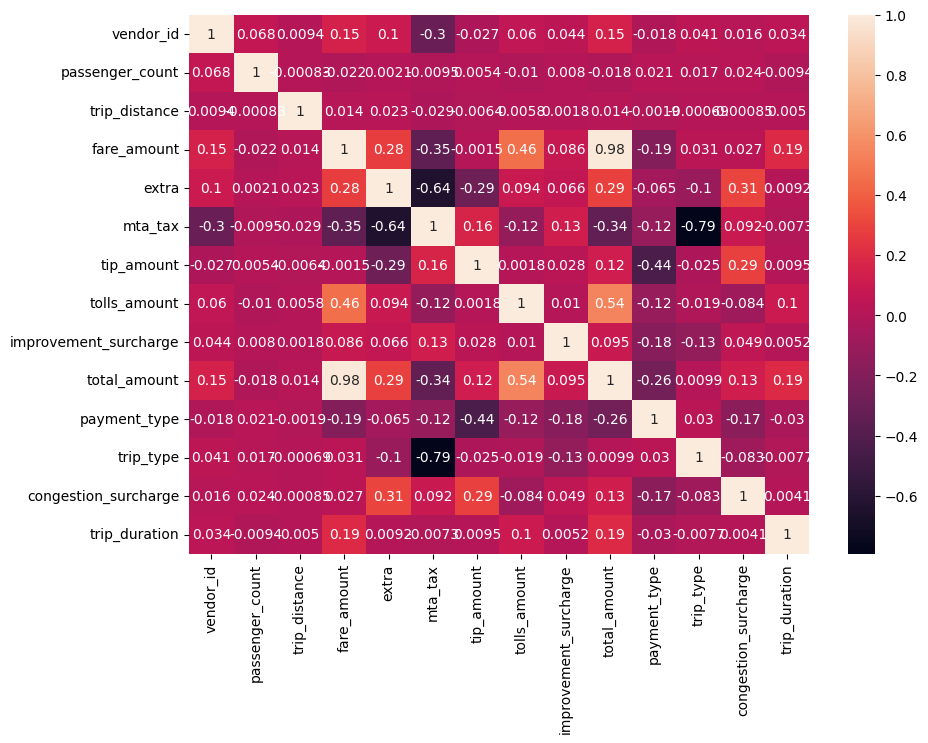

In [104]:
plt.figure(figsize=(10,7))
sns.heatmap(df1_num_correlation, annot=True);

### 2.6.2. Categorical Statistics

In [105]:
cat_statistics = cat_data.describe().T.reset_index()
cat_statistics.rename(columns={'index': 'features'}, inplace=True)
cat_statistics

,features,count,unique,top,freq
0,store_and_fwd_flag,270178,2,N,268150
1,ratecode_id,486775,8,1.0,259857
2,pick_up_location_id,486775,260,74,45692
3,drop_off_location_id,486775,261,74,20307


In [106]:
# list of categorical attributes to calculate Cramer's V correlation
cat_data_list = cat_data.columns.tolist()

corr_dict = {}

for i in range(len(cat_data_list)):
    corr_list = []
    for j in range(len(cat_data_list)):
        ref = cat_data_list[i]
        feat = cat_data_list[j]
        
        corr = cramer_v(cat_data[ref], cat_data[feat])
        corr_list.append(corr)
        
    corr_dict[ref] = corr_list

In [107]:
df1__cat_correlation = pd.DataFrame(corr_dict)
df1__cat_correlation.set_index(df1__cat_correlation.columns, inplace=True)
df1__cat_correlation

,store_and_fwd_flag,ratecode_id,pick_up_location_id,drop_off_location_id
store_and_fwd_flag,0.999753,0.008632,0.081425,0.108473
ratecode_id,0.008632,1.000007,0.263544,0.279031
pick_up_location_id,0.081425,0.263544,1.000266,0.147290
drop_off_location_id,0.108473,0.279031,0.147290,1.000267


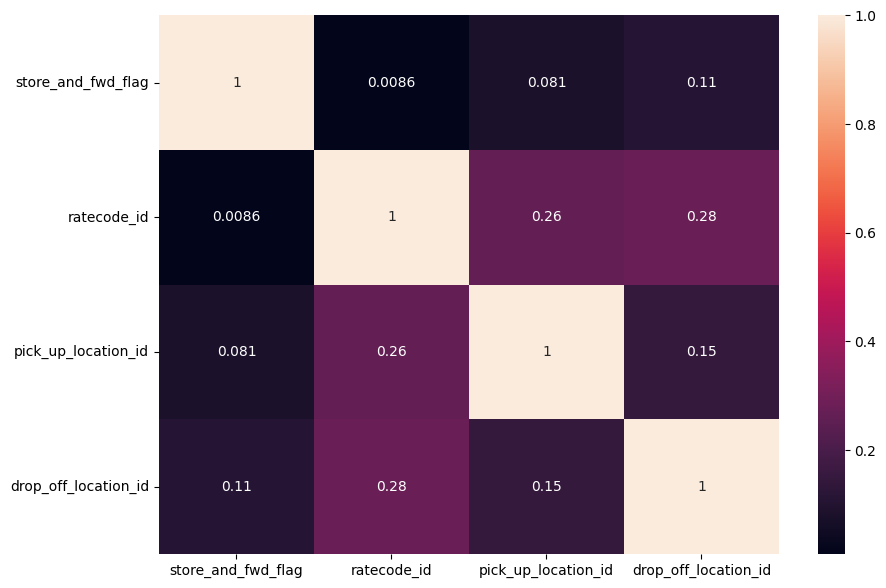

In [108]:
plt.figure(figsize=(10,7))
sns.heatmap(df1__cat_correlation, annot=True);

In [109]:
pickle.dump(df1, open("../data/processed/df1.pkl", "wb"))

# 3. Data Filtering

In [114]:
df2 = pickle.load(open("../data/processed/df1.pkl", "rb"))

## 3.1. Rows Filtering

Since we have the 99% amount of the data lower than 82 min, we will filter the rows lower than this duration

In [115]:
df2['trip_duration'].describe(percentiles=[.90, .95, .99])

count    486775.000000
mean         22.330992
std          64.490140
min           0.000000
50%          15.000000
90%          40.000000
95%          51.000000
99%          82.716667
max        1439.650000
Name: trip_duration, dtype: float64

In [116]:
# trip_duration
df2 = df2[(df2['trip_duration'] > 1 ) & (df2['trip_duration'] < 82)]

## passenger_count
#df2 = df2[df2['passenger_count'] > 0]
#
## trip_distance
#df2 = df2[df2['trip_distance'] < 100000]

# 


## 3.2. Columns Filtering

In [117]:
categorical = ['pick_up_location_id', 'drop_off_location_id']
numerical = ['trip_distance']

In [118]:
df2[categorical].dtypes

pick_up_location_id     object
drop_off_location_id    object
dtype: object

In [119]:
df2[categorical] = df2[categorical].astype(str)

In [120]:
df2[numerical].dtypes

trip_distance    float64
dtype: object

In [121]:
pickle.dump(df2, open("../data/processed/df2.pkl", "wb"))

# 4. Feature Engineering

In [122]:
df3 = pickle.load(open("../data/processed/df2.pkl", "rb"))

In [123]:
pickle.dump(df3, open("../data/processed/df3.pkl", "wb"))

# 5. Exploratory Data Analysis

In [124]:
df4 = pickle.load(open("../data/processed/df3.pkl", "rb"))

In [125]:
pickle.dump(df4, open("../data/processed/df4.pkl", "wb"))

# 6. Data Preparation

In [126]:
df5 = pickle.load(open("../data/processed/df4.pkl", "rb"))

In [127]:
pickle.dump(df5, open("../data/processed/df5.pkl", "wb"))

# 7. Feature Selection

In [128]:
df6 = pickle.load(open("../data/processed/df5.pkl", "rb"))

In [129]:
train_dicts = df6[categorical + numerical].to_dict(orient="records")
train_dicts[:5]

[{'pick_up_location_id': '43',
  'drop_off_location_id': '151',
  'trip_distance': 1.01},
 {'pick_up_location_id': '166',
  'drop_off_location_id': '239',
  'trip_distance': 2.53},
 {'pick_up_location_id': '41',
  'drop_off_location_id': '42',
  'trip_distance': 1.12},
 {'pick_up_location_id': '168',
  'drop_off_location_id': '75',
  'trip_distance': 1.99},
 {'pick_up_location_id': '75',
  'drop_off_location_id': '75',
  'trip_distance': 0.45}]

In [130]:
dv = DictVectorizer()

X_train = dv.fit_transform(train_dicts)
y_train = df6['trip_duration'].values

# 8. Machine Learning Models

## 8.1. Linear Regression

In [133]:
# model definition
lr = LinearRegression()

# model training
lr.fit(X_train, y_train)

# model predictions
lr_preds = lr.predict(X_train)

# model evaluation
lr_error = mean_squared_error(y_train, lr_preds, squared=False)

lr_error

12.131868402701459

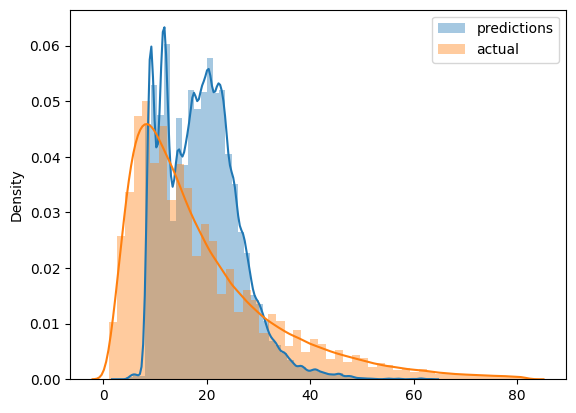

In [134]:
sns.distplot(lr_preds, label="predictions")
sns.distplot(y_train, label="actual")
plt.legend()

## 8.3. Lasso

In [135]:
# model definition (Lasso)
lasso_model = Lasso(alpha=0.001)

# model fit
lasso_model.fit(X_train, y_train)

# model predictions
y_pred_lasso = lasso_model.predict(X_train)

# model evaluation
lasso_error = mean_squared_error(y_train, y_pred_lasso, squared=False)
lasso_error

12.03696669426479

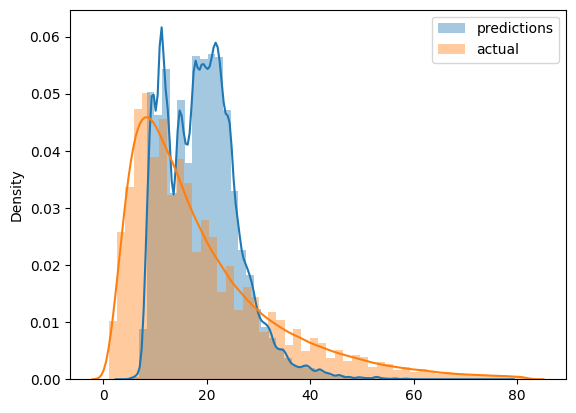

In [139]:
sns.distplot(y_pred_lasso, label="predictions")
sns.distplot(y_train, label="actual")
plt.legend()

## 8.4. Ridge

In [137]:
# model definition (Ridge)
ridge_model = Ridge()

# model fit
ridge_model.fit(X_train, y_train)

# model predictions
y_pred_ridge = ridge_model.predict(X_train)

# model evaluation
ridge_error = mean_squared_error(y_train, y_pred_ridge, squared=False)
ridge_error

12.828995506826992

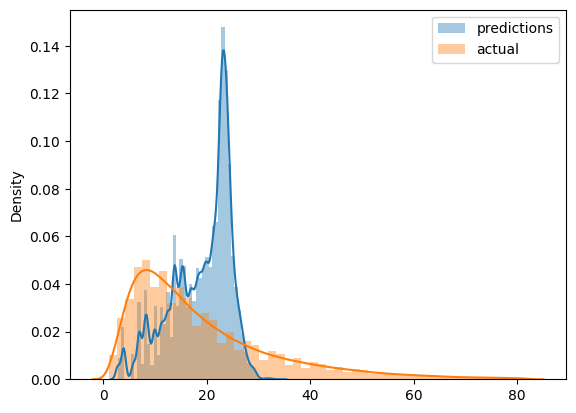

In [138]:
sns.distplot(y_pred_ridge, label="predictions")
sns.distplot(y_train, label="actual")
plt.legend()